<a href="https://colab.research.google.com/github/9645258/aiffel/blob/main/02_goingdeeper/01_nlp/%5BGD-14%5Dnlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GD NLP 14 : BERT pretrained model 제작**

- **mini BERT 만들기**

- **한글 코퍼스를 가공하여 BERT pretrain용 데이터셋을 잘 생성하였다.**  
MLM, NSP task의 특징이 잘 반영된 pretrain용 데이터셋 생성과정이 체계적으로 진행되었다.  

- **구현한 BERT 모델의 학습이 안정적으로 진행됨을 확인하였다.**  
학습진행 과정 중에 MLM, NSP loss의 안정적인 감소가 확인되었다.  

- **1M짜리 mini BERT 모델의 제작과 학습이 정상적으로 진행되었다.**  
학습된 모델 및 학습과정의 시각화 내역이 제출되었다.

## **1. 데이터 준비**

### **1-1. 라이브러리 import**

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import re
import json
import math
import copy
import shutil
import random
import zipfile
import collections
import numpy as np
import pandas as pd
import sentencepiece as spm
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
import tensorflow.keras.backend as K

import warnings
warnings.filterwarnings(action='ignore')

### **1-2. Random Seed 설정**

In [ ]:
random_seed = 2525
random.seed(random_seed) 
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

### **1-3. 데이터 import**

In [ ]:
corpus_file = 'C:/Users/96452/00_work/01_GD/14/data/kowiki.txt'

### **1-4. 데이터 확인**

- **데이터 확인**

In [ ]:
f = open(corpus_file, 'r', encoding='utf-8')
lines = f.readlines()
for idx, line in enumerate(lines):
    print(line.strip(), end="\n\n")
    if idx == 3: break;
f.close()

지미 카터

제임스 얼 "지미" 카터 주니어(, 1924년 10월 1일 ~ )는 민주당 출신 미국 39번째 대통령 (1977년 ~ 1981년)이다.

지미 카터는 조지아주 섬터 카운티 플레인스 마을에서 태어났다. 조지아 공과대학교를 졸업하였다. 그 후 해군에 들어가 전함·원자력·잠수함의 승무원으로 일하였다. 1953년 미국 해군 대위로 예편하였고 이후 땅콩·면화 등을 가꿔 많은 돈을 벌었다. 그의 별명이 "땅콩 농부" (Peanut Farmer)로 알려졌다.

1962년 조지아 주 상원 의원 선거에서 낙선하나 그 선거가 부정선거 였음을 입증하게 되어 당선되고, 1966년 조지아 주 지사 선거에 낙선하지만 1970년 조지아 주 지사를 역임했다. 대통령이 되기 전 조지아주 상원의원을 두번 연임했으며, 1971년부터 1975년까지 조지아 지사로 근무했다. 조지아 주지사로 지내면서, 미국에 사는 흑인 등용법을 내세웠다.



- **데이터 내 총 문단 수 확인**

In [ ]:
len(lines)

3957761

## **2. Tokenizer 준비**

### **2-1. SentencePiece 모델 생성** 

- **vocab_size가 8,000인 sentencepiece 모델 생성**

In [ ]:
prefix = 'ko_8000'
vocab_size = 8000

spm.SentencePieceTrainer.train(
    f"--input={corpus_file} --model_prefix={prefix} --vocab_size={vocab_size + 7}" + 
    " --model_type=bpe" +
    " --max_sentence_length=999999" +
    " --pad_id=0 --pad_piece=[PAD]" +
    " --unk_id=1 --unk_piece=[UNK]" +
    " --bos_id=2 --bos_piece=[BOS]" +
    " --eos_id=3 --eos_piece=[EOS]" +
    " --user_defined_symbols=[SEP],[CLS],[MASK]")

### **2-2. SentencePiece 모델 확인** 

- **모델 생성 및 import 확인**

In [ ]:
model_dir = 'C:/Users/96452/00_work/01_GD/14/data/'
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}ko_8000.model")

True

- **vocab size 확인**

In [ ]:
vocab.get_piece_size()

8007

- **특수 토큰 확인**

In [ ]:
[vocab.id_to_piece(idx) for idx in range(0, 7)]

['[PAD]', '[UNK]', '[BOS]', '[EOS]', '[SEP]', '[CLS]', '[MASK]']

- **일반 토큰 확인**

In [ ]:
[vocab.id_to_piece(idx) for idx in range(7, 17)]

['▁1', '▁이', '으로', '에서', '▁있', '▁2', '▁그', '▁대', '▁사', '이다']

## **3. 데이터 전처리**

### **3-1. MASK**

- **MASK 생성 함수 정의**  
MASK 비율 전체 토큰의 15% (80% - `[MASK]` 토큰 / 10% - 랜덤 토큰 / 10% - 원래 토큰)

In [ ]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):

    cand_idx = []
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])

    random.shuffle(cand_idx)

    mask_lms = []
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:
            break
        if len(mask_lms) + len(index_set) > mask_cnt:
            continue
        dice = random.random()
        for index in index_set:
            masked_token = None
            if dice < 0.8:
                masked_token = "[MASK]"
            elif dice < 0.9:
                masked_token = tokens[index]
            else:
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token

    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]

    return tokens, mask_idx, mask_label

- **MASK 생성 예시 확인**

In [ ]:
tokens_org = vocab.encode_as_pieces("장마가 끝났지만 아직도 비가 와")

In [ ]:
vocab_list = []
for id in range(7, len(vocab)):
    if not vocab.is_unknown(id):
        vocab_list.append(vocab.id_to_piece(id))

In [ ]:
mask_cnt = int((len(tokens_org) - 3) * 0.5)
tokens, mask_idx, mask_label = create_pretrain_mask(tokens_org.copy(), mask_cnt, vocab_list)

In [ ]:
print("원본 예시 문장:", tokens_org, '\n')
print("MASK가 적용된 문장:", tokens)
print("MASK 적용 부분:", "idx -", mask_idx, "/ mask_label -", mask_label)

원본 예시 문장: ['▁장', '마', '가', '▁끝', '났', '지만', '▁아직', '도', '▁비', '가', '▁와'] 

MASK가 적용된 문장: ['[MASK]', '[MASK]', '[MASK]', '▁끝', '났', '지만', '▁아직', '도', '▁비', '가', '[MASK]']
MASK 적용 부분: idx - [0, 1, 2, 10] / mask_label - ['▁장', '마', '가', '▁와']


### **3-2. NSP**

- **토큰 길이 제한**

In [ ]:
def trim_tokens(tokens_a, tokens_b, max_seq):

    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

- **NSP 데이터 생성**

In [ ]:
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):

    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):
        current_chunk.append(doc[i])
        current_length += len(doc[i])
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):

            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])

            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            if random.random() < 0.5:
                is_next = 0
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1

            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)

            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)

            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

            instance = {
                "예시 문장 토큰 확인": tokens,
                "예시 문장 segment 확인": segment,
                "is_next": is_next,
                "MASK 적용 부분 - idx": mask_idx,
                "MASK 적용 부분 - label": mask_label
            }
            instances.append(instance)

            current_chunk = []
            current_length = 0
    return instances

- **NSP 생성 예시 확인**

In [ ]:
string = """장마가 끝났지만 아직도 비가 와
이제는 그만 왔으면 좋겠어
"""

In [ ]:
doc = [vocab.encode_as_pieces(line) for line in string.split("\n")]
instances = create_pretrain_instances(vocab, doc, 64, 0.15, vocab_list)

In [ ]:
for key, value in instances[0].items():
    print(f"{key}: {value}", end = '\n')

예시 문장 토큰 확인: ['[CLS]', '▁이', '제는', '▁그', '만', '▁왔', '으면', '▁좋', '겠', '어', '[SEP]', '▁장', '마', '가', '▁끝', '났', '지만', '[MASK]', '[MASK]', '▁비', '가', '[MASK]', '[SEP]']
예시 문장 segment 확인: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
is_next: 0
MASK 적용 부분 - idx: [17, 18, 21]
MASK 적용 부분 - label: ['▁아직', '도', '▁와']


## **4. pretrain 데이터**

### **4-1. pretrain 데이터 생성**

- **pretrain 데이터 생성 함수 정의**

In [ ]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):
            vocab_list.append(vocab.id_to_piece(id))

    line_cnt = 0
    with open(in_file, "r", encoding = 'utf-8') as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r", encoding = 'utf-8') as in_f:
        with open(out_file, "w", encoding = 'utf-8') as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":
                    if 0 < len(doc):
                        save_pretrain_instances(out_f, doc)
                        doc = []
                else:
                    pieces = vocab.encode_as_pieces(line)
                    if 0 < len(pieces):
                        doc.append(pieces)
            if 0 < len(doc):
                save_pretrain_instances(out_f, doc)
                doc = []

- **pretrain 데이터 생성**

In [ ]:
pretrain_json_path = 'C:/Users/96452/00_work/01_GD/14/data/bert_pre_train.json'
make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)

  0%|          | 0/3957761 [00:00<?, ?it/s]

- **pretrain 데이터 수 확인**

In [ ]:
total = 0

with open(pretrain_json_path, "r", encoding = 'utf-8') as f:
    for line in f:
        total += 1

total

918189

### **4-2. pretrain 데이터 import**

- **pretrain 데이터 import 함수 생성**

In [ ]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    
    total = 0
    with open(filename, "r", encoding = 'utf-8') as f:
        for line in f:
            total += 1
            
            if count is not None and count <= total:
                break

    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r", encoding = 'utf-8') as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("early stop", total, i)
                break
            data = json.loads(line)

            enc_token = [vocab.piece_to_id(p) for p in data["예시 문장 토큰 확인"]]
            enc_token += [0] * (n_seq - len(enc_token))

            segment = data["예시 문장 segment 확인"]
            segment += [0] * (n_seq - len(segment))

            label_nsp = data["is_next"]

            mask_idx = np.array(data["MASK 적용 부분 - idx"], dtype=np.int)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["MASK 적용 부분 - label"]], dtype=np.int)
            label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

- **pretrain 데이터 import**

In [ ]:
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128, count=114773)

  0%|          | 0/114773 [00:00<?, ?it/s]

early stop 114773 114773


- **학습 데이터 분할**

In [ ]:
pre_train_inputs = (pre_train_inputs[0][100:], pre_train_inputs[1][100:])
pre_train_labels = (pre_train_labels[0][100:], pre_train_labels[1][100:])

- **테스트 데이터 분할**

In [ ]:
test_input = (pre_train_inputs[0][:100], pre_train_inputs[1][:100])
test_label = (pre_train_labels[0][:100], pre_train_labels[1][:100])

## **5. BERT 모델 생성**

### **5-1. 유틸리티 함수**

In [ ]:
def get_pad_mask(tokens, i_pad=0):
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask

@tf.function(experimental_relax_shapes=True)
def gelu(x):
    return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))

def kernel_initializer(stddev=0.02):
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)

def bias_initializer():
    return tf.zeros_initializer

### **5-2. 데이터 관리**

In [ ]:
class Config(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, 'r', encoding = 'utf-8') as f:
            config = json.loads(f.read())
            return Config(config)

### **5-3. 임베딩 레이어**

In [ ]:
class SharedEmbedding(tf.keras.layers.Layer):

    def __init__(self, config, name="weight_shared_embedding"):
        
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):

        if mode == "embedding":
            return self._embedding(inputs)
        elif mode == "linear":
            return self._linear(inputs)
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):

        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):

        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])
        return outputs

### **5-4. DotProduct**

In [ ]:
class ScaleDotProductAttention(tf.keras.layers.Layer):

    def __init__(self, name="scale_dot_product_attention"):

        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

### **5-5. 멀티 헤드 어텐션**

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, config, name="multi_head_attention"):
        
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

        self.attention = ScaleDotProductAttention(name="self_attention")
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):

        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])
        
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)

        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)

        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])
        attn_out = self.W_O(attn_out)

        return attn_out

### **5-6. FFNN**

In [ ]:
class PositionWiseFeedForward(tf.keras.layers.Layer):

    def __init__(self, config, name="feed_forward"):
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

### **5-7. 인코더**

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):

    def __init__(self, config, name="encoder_layer"):
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

### **5-8. BERT**

In [ ]:
class BERT(tf.keras.layers.Layer):

    def __init__(self, config, name="bert"):
        
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):

        enc_tokens, segments = inputs

        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = self.embedding(enc_out, mode="linear")
        
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):

        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        
        return embed

### **5-9. PositionalEmbedding**

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):

    def __init__(self, config, name="position_embedding"):

        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):

        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        
        return embed

## **6. Pretrain을 위한 BERT 모델**

### **6-1. Pretrain을 위한 BERT 모델 정의**

- **Encoder Layer class**

In [ ]:
class PooledOutput(tf.keras.layers.Layer):
    
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(config.d_model, activation=tf.nn.tanh, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.dense2 = tf.keras.layers.Dense(n_output, use_bias=False, activation=tf.nn.softmax, name="nsp",
                                            kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
 
    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs

- **Pretrain BERT 모델 생성**

In [ ]:
def build_model_pre_train(config):
    
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    
    return model

### **6-2. Pretrain을 위한 BERT 모델 생성**

In [ ]:
config = Config({"d_model": 512, "n_head": 8, "d_head": 64, "dropout": 0.1, "d_ff": 1024, 
                 "layernorm_epsilon": 0.001, "n_layer": 3, "n_seq": 256, "n_vocab": 0, "i_pad": 0})

config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()

pre_train_model = build_model_pre_train(config)
pre_train_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_tokens (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
segments (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (BERT)                     ((None, 512), (None, 10541056    enc_tokens[0][0]                 
                                                                 segments[0][0]                   
__________________________________________________________________________________________________
pooled_nsp (PooledOutput)       (None, 2)            263680      bert[0][0]                   

## **7. BERT 모델 학습**

### **7-1. 옵티마이저 설정**

In [ ]:
class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr

In [ ]:
def lm_loss(y_true, y_pred):
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)

    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * 20 

In [ ]:
def lm_acc(y_true, y_pred):
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)

    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask

    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy

In [ ]:
epochs = 10
batch_size = 64

In [ ]:
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [ ]:
pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss), optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})

### **7-2. 모델 학습**

In [ ]:
history = pre_train_model.fit(pre_train_inputs, pre_train_labels, epochs=epochs, batch_size=batch_size)

Epoch 1/10
1792/1792 [==============================] - 107s 57ms/step - loss: 18.8720 - nsp_loss: 0.6455 - mlm_loss: 18.2265 - nsp_acc: 0.5931 - mlm_lm_acc: 0.1236
Epoch 2/10
1792/1792 [==============================] - 100s 56ms/step - loss: 16.2499 - nsp_loss: 0.6199 - mlm_loss: 15.6300 - nsp_acc: 0.6164 - mlm_lm_acc: 0.1505
Epoch 3/10
1792/1792 [==============================] - 106s 59ms/step - loss: 13.6351 - nsp_loss: 0.6132 - mlm_loss: 13.0219 - nsp_acc: 0.6230 - mlm_lm_acc: 0.2069
Epoch 4/10
1792/1792 [==============================] - 109s 61ms/step - loss: 12.6839 - nsp_loss: 0.6084 - mlm_loss: 12.0755 - nsp_acc: 0.6311 - mlm_lm_acc: 0.2354
Epoch 5/10
1792/1792 [==============================] - 108s 60ms/step - loss: 12.0543 - nsp_loss: 0.6030 - mlm_loss: 11.4513 - nsp_acc: 0.6429 - mlm_lm_acc: 0.2571
Epoch 6/10
1792/1792 [==============================] - 109s 61ms/step - loss: 11.5579 - nsp_loss: 0.5960 - mlm_loss: 10.9619 - nsp_acc: 0.6581 - mlm_lm_acc: 0.2746
Epoch 7/10

## **8. 모델 평가**

### **8-1. 학습 결과 시각화**

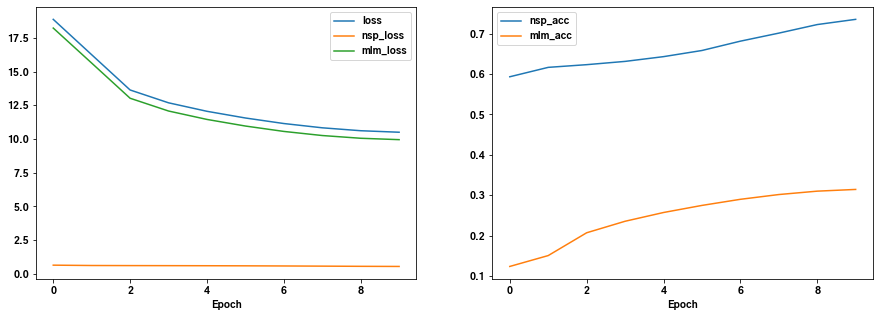

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['nsp_loss'], label='nsp_loss')
plt.plot(history.history['mlm_loss'], label='mlm_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['nsp_acc'], label='nsp_acc')
plt.plot(history.history['mlm_lm_acc'], label='mlm_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

### **8-2. 모델 평가**

In [ ]:
for _idx in np.random.randint(100, size=5).tolist():

    print("문장:", vocab.decode_ids(test_input[0][_idx].tolist()), end="\n\n")
    print("NSP Answer:".ljust(13), bool(test_label[0][_idx]))
    print("[MASK] Answer:".ljust(13), vocab.decode_ids(test_label[1][_idx].tolist()).split(), end="\n\n")

    nsp_predict, mask_predict = pre_train_model((test_input[0][_idx].reshape(1, -1), test_input[1][_idx].reshape(1, -1)))

    mask_predict = [np.argmax(token) for token in mask_predict[0]]
    mask_predict *= np.clip(test_label[1][_idx], 0, 1)

    print("NSP Predict:".ljust(13), np.argmax(nsp_predict))
    print("[MASK] Predict:".ljust(13), vocab.decode_ids(mask_predict.tolist()).split(), end="\n\n")

문장: [CLS] 방정식[SEP] 방정식(方程式, )은 미지수가 포함된 식에서, 그 미지수에 특정한 값을 주었을 때만 성립하는 등식이다. 이때, 방정식을[MASK][MASK][MASK][MASK] 하는(성립하게[MASK][MASK][MASK][MASK][MASK] 값을 해 또는 근이라 한다. 방정식의 해는 없을 수도 있고, 여러[MASK][MASK] 수도 있고, 모든 값일 수도 있다. 전자의 경우는 불능이라고 하고, 중자의 경우는[MASK][MASK][MASK][MASK] 후자의 경우는 항등식(부정)이라 한다.[MASK] 들어[MASK][MASK][SEP]

NSP Answer:   True
[MASK] Answer: ['참이', '되게', '하는)', '특정', '문자의', '개일', '방정식,', '예를', '은', '문']

NSP Predict:  1
[MASK] Predict: ['정수야', '해)))의', '값일', '항정식,', '예를', '전는']

문장: [CLS]자라며 양측 진영에서 모두 비판받은 대통령으로[MASK][MASK][MASK][MASK] 행정수도 이전과 혁신도시 등 지방 균형 발전을 추진하였으나[MASK][MASK][MASK][MASK][MASK] 수도 이전은 헌법재판소에서 관습헌법이라는 이유로 위헌 결정을[MASK] 행정도시로 선회하였다.[SEP] 주요 실책으로는 정치적으로 친인척 및 측근비리, 사회적으로 교육 정책[MASK] 부동산 정책의[MASK][MASK] 경제적으로 양극화 심화에 따른 민생경제 파탄, 외교적으로 햇볕정책의[MASK] 등이 꼽힌다. 부동산[MASK][MASK] 전반적으로[SEP]

NSP Answer:   False
[MASK] Answer: ['평가받는다.', '세종특별자치시의', '내려', '정치적으로', '및', '실패,', '실패', '정책은']

NSP Predict:  0
[MASK] Predict: ['출명하였다,', '제재년하였다일', '위한', '정치적으로', '및', '정책,', '정책',

### **8-3. 테스트 데이터 평가**

In [ ]:
_ = pre_train_model.evaluate(test_input, test_label)

4/4 [==============================] - 0s 14ms/step - loss: 10.4598 - nsp_loss: 0.5569 - mlm_loss: 9.9029 - nsp_acc: 0.7400 - mlm_lm_acc: 0.3449


||**MLM**|**NSP**|**Total**|
|:---:|:---:|:---:|:---:|
|**Loss**|11.743|0.677|12.419|
|**Accuracy**|0.281|0.560||

## **9. 회고**

### **9-1. 프로젝트 회고**

이번 프로젝트는 크게 오류 없이 잘 진행되었다. 그렇기 때문에 다른 프로젝트에 비해 직접 따라치며 작성하는 시간을 가져볼 수 있어서 좋았다. 

이번에 작업하면서 문제가 되었던 부분은 2군데 였는데, 항상 문제가 되는 인코딩 부분과 파일 저장 부분이었다. 인코딩의 경우 코랩에서 진행할 때나 LMS 환경에서는 크게 문제가 된 적이 없는데, 꼭 로컬에서 진행하는 경우 encoding = 'utf-8'을 넣어주지 않으면 파일을 읽거나 쓰는 부분에서 계속 오류가 발생한다. 매번 쓰기가 귀찮아서 원인을 찾고 싶지만 일단 시간이 급했기에 그냥 오늘은 평소와 같이 인코딩 부분을 기재하고 진행했다.  

그리고 파일 저장 부분은 왜 그런지 모르는데 계속 오류가 났디. 그래서 커널을 다시 실행을 여러 차례 진행했더니 동일한 코드로 잘 진행되는 결과를 얻을 수 있었다. 매번 궁금하고 제일 힘든 부분이 딱히 이유를 알 수 없는 오류인 것 같다. 계속 오류가 나거나 계속 잘 되는 일괄적인 패턴을 안보이고, 되다가 안되는 경우에는 이게 맞는건지 틀린건지 감이 잘 안잡혀서 다음에 진행할 때에도 문제가 발생하게 되는 것 같다. 오류를 만났을 때에는 꼭 되짚어보고 원인을 확인하고 넘어가는 습관을 들이는 것이 중요할 것 같다. 

### **9-2. 참고 자료**

1. https://github.com/YAGI0423/aiffel_going_deeper_nlp/blob/main/going_deeper_14/GD14_v2_2.ipynb